# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
np.random.seed(2325595) # Set seed for numpy. Put your SID instead of number '42'
random.seed(2325595) # Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
tf.random.set_seed(2325595) # Set seed for TensorFlow. Put your SID instead of number '42'
K.clear_session()


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    return model

## 2 clients

In [7]:
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, random_state=2325595)



In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)


(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)

Epoch 1/5
938/938 [==============================] - 12s 9ms/step - loss: 0.3340 - accuracy: 0.9058
Epoch 2/5
938/938 [==============================] - 7s 7ms/step - loss: 0.1554 - accuracy: 0.9548
Epoch 3/5
938/938 [==============================] - 6s 7ms/step - loss: 0.1060 - accuracy: 0.9683
Epoch 4/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0784 - accuracy: 0.9764
Epoch 5/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0593 - accuracy: 0.9830
Epoch 1/5
938/938 [==============================] - 15s 10ms/step - loss: 0.3537 - accuracy: 0.8996
Epoch 2/5
938/938 [==============================] - 6s 7ms/step - loss: 0.1668 - accuracy: 0.9523
Epoch 3/5
938/938 [==============================] - 5s 6ms/step - loss: 0.1144 - accuracy: 0.9665
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0866 - accuracy: 0.9739
Epoch 5/5
938/938 [==============================] - 9s 9ms/step - loss: 0.0673 - accuracy: 0.9804


In [10]:
# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [13]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 4s - loss: 0.5199 - accuracy: 0.8464 - 4s/epoch - 14ms/step
Test accuracy: 0.8464000225067139


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [15]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 4s 12ms/step
(10000, 10)


In [16]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       980
           1       0.95      0.84      0.89      1135
           2       0.61      0.97      0.75      1032
           3       0.88      0.90      0.89      1010
           4       0.99      0.79      0.88       982
           5       0.70      0.95      0.80       892
           6       0.94      0.87      0.91       958
           7       0.87      0.94      0.90      1028
           8       0.88      0.81      0.85       974
           9       0.97      0.64      0.77      1009

    accuracy                           0.85     10000
   macro avg       0.88      0.85      0.85     10000
weighted avg       0.88      0.85      0.85     10000



In [17]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))


Accuracy test set: 0.8464
precison test set: 0.8775455396785825
Recall test set: 0.8464
f-score test set: 0.8493066701172464


In [18]:
test_precision= []
test_recall = []
test_f1_score = []
test_accuracy=[]

In [19]:
test_accuracy.append(0.8464)
test_precision.append(0.8775455396785825)
test_recall.append(0.8464)
test_f1_score.append(0.8493066701172464)

In [20]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8464]
[0.8775455396785825]
[0.8464]
[0.8493066701172464]


## 4 clients

In [21]:
# split data into 4 clients

In [22]:
client_1 = (x_train[0:15000], y_train[0:15000])
client_2 = (x_train[15000:30000], y_train[15000:30000])
client_3 = (x_train[30000:45000], y_train[30000:45000])
client_4 = (x_train[45000:], y_train[45000:])


In [23]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [24]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])

Epoch 1/5
469/469 [==============================] - 6s 4ms/step - loss: 0.4469 - accuracy: 0.8746
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.2139 - accuracy: 0.9387
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1479 - accuracy: 0.9591
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1119 - accuracy: 0.9693
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0847 - accuracy: 0.9777
Epoch 1/5
469/469 [==============================] - 5s 6ms/step - loss: 2.3151 - accuracy: 0.1021
Epoch 2/5
469/469 [==============================] - 5s 12ms/step - loss: 2.2983 - accuracy: 0.1168
Epoch 3/5
469/469 [==============================] - 6s 13ms/step - loss: 2.2869 - accuracy: 0.1317
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 2.2744 - accuracy: 0.1387
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 2.2534 - accuracy: 0.1530
Epoch 1

In [25]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2,  weights3,  weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights

In [26]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights())

In [27]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 4s - loss: 2.2270 - accuracy: 0.3094 - 4s/epoch - 11ms/step
Test accuracy: 0.3093999922275543


In [28]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 2s 4ms/step
(10000, 10)


In [29]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.3094
precison test set: 0.3704074236615539
Recall test set: 0.3094
f-score test set: 0.28292712051564833


In [30]:
test_accuracy.append(0.3094)
test_precision.append(0.3704074236615539)
test_recall.append(0.3094)
test_f1_score.append(0.28292712051564833)

In [31]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8464, 0.3094]
[0.8775455396785825, 0.3704074236615539]
[0.8464, 0.3094]
[0.8493066701172464, 0.28292712051564833]


## 6 clients cell


In [32]:
client_1 = (x_train[0:10000], y_train[0:10000])
client_2 = (x_train[10000:20000], y_train[10000:20000])
client_3 = (x_train[20000:30000], y_train[20000:30000])
client_4 = (x_train[30000:40000], y_train[30000:40000])
client_5 = (x_train[40000:50000], y_train[40000:50000])
client_6 = (x_train[50000:], y_train[50000:])

In [33]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [34]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])
client5_model = train_client_model(client5_model, client_5[0], client_1[1])
client6_model = train_client_model(client6_model, client_6[0], client_1[1])

Epoch 1/5
313/313 [==============================] - 6s 10ms/step - loss: 0.5272 - accuracy: 0.8573
Epoch 2/5
313/313 [==============================] - 3s 8ms/step - loss: 0.2510 - accuracy: 0.9287
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 0.1841 - accuracy: 0.9474
Epoch 4/5
313/313 [==============================] - 3s 8ms/step - loss: 0.1419 - accuracy: 0.9591
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.1124 - accuracy: 0.9696
Epoch 1/5
313/313 [==============================] - 7s 13ms/step - loss: 2.3214 - accuracy: 0.1012
Epoch 2/5
313/313 [==============================] - 3s 10ms/step - loss: 2.2936 - accuracy: 0.1240
Epoch 3/5
313/313 [==============================] - 3s 10ms/step - loss: 2.2794 - accuracy: 0.1413
Epoch 4/5
313/313 [==============================] - 2s 5ms/step - loss: 2.2599 - accuracy: 0.1526
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 2.2327 - accuracy: 0.1802
Epoch 

In [35]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2,  weights3,  weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights

In [36]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(),client5_model.get_weights(),client6_model.get_weights())

In [37]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 3s - loss: 2.2864 - accuracy: 0.1768 - 3s/epoch - 9ms/step
Test accuracy: 0.17679999768733978


In [38]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 2s 6ms/step
(10000, 10)


In [39]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.1768
precison test set: 0.18168698182650236
Recall test set: 0.1768
f-score test set: 0.14958748329847868


In [40]:
test_accuracy.append(0.1768)
test_precision.append(0.18168698182650236)
test_recall.append(0.1768)
test_f1_score.append(0.14958748329847868)

In [41]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8464, 0.3094, 0.1768]
[0.8775455396785825, 0.3704074236615539, 0.18168698182650236]
[0.8464, 0.3094, 0.1768]
[0.8493066701172464, 0.28292712051564833, 0.14958748329847868]


## 8 clients


In [42]:
client_1 = (x_train[0:7500], y_train[0:7500])
client_2 = (x_train[7500:15000], y_train[7500:15000])
client_3 = (x_train[15000:22500], y_train[15000:22500])
client_4 = (x_train[22500:30000], y_train[22500:30000])
client_5 = (x_train[30000:37500], y_train[30000:37500])
client_6 = (x_train[37500:45000], y_train[37500:45000])
client_7 = (x_train[45000:52500], y_train[45000:52500])
client_8 = (x_train[52500:], y_train[52500:]) 

In [43]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [44]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])

Epoch 1/5
235/235 [==============================] - 3s 6ms/step - loss: 0.5701 - accuracy: 0.8487
Epoch 2/5
235/235 [==============================] - 1s 5ms/step - loss: 0.2596 - accuracy: 0.9263
Epoch 3/5
235/235 [==============================] - 1s 6ms/step - loss: 0.1917 - accuracy: 0.9456
Epoch 4/5
235/235 [==============================] - 2s 7ms/step - loss: 0.1513 - accuracy: 0.9567
Epoch 5/5
235/235 [==============================] - 2s 9ms/step - loss: 0.1155 - accuracy: 0.9700
Epoch 1/5
235/235 [==============================] - 6s 12ms/step - loss: 0.6065 - accuracy: 0.8316
Epoch 2/5
235/235 [==============================] - 3s 11ms/step - loss: 0.2790 - accuracy: 0.9213
Epoch 3/5
235/235 [==============================] - 3s 11ms/step - loss: 0.2046 - accuracy: 0.9419
Epoch 4/5
235/235 [==============================] - 2s 7ms/step - loss: 0.1614 - accuracy: 0.9549
Epoch 5/5
235/235 [==============================] - 1s 6ms/step - loss: 0.1238 - accuracy: 0.9664
Epoch 1

In [45]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8) / 8)
    return new_weights

In [46]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights())

In [47]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 3s - loss: 1.4514 - accuracy: 0.6156 - 3s/epoch - 9ms/step
Test accuracy: 0.6155999898910522


In [48]:
prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 [==============================] - 3s 8ms/step
(10000, 10)


In [49]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

Accuracy test set: 0.6156
precison test set: 0.8490000243742335
Recall test set: 0.6156
f-score test set: 0.5857600932049642


In [50]:
test_accuracy.append(0.6156)
test_precision.append(0.8490000243742335)
test_recall.append(0.6156)
test_f1_score.append(0.5857600932049642)

In [51]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8464, 0.3094, 0.1768, 0.6156]
[0.8775455396785825, 0.3704074236615539, 0.18168698182650236, 0.8490000243742335]
[0.8464, 0.3094, 0.1768, 0.6156]
[0.8493066701172464, 0.28292712051564833, 0.14958748329847868, 0.5857600932049642]


## 10 clients

In [52]:
client_1 = (x_train[0:6000],y_train[0:6000])
client_2= (x_train[6000:12000],y_train[6000:12000])
client_3= (x_train[12000:18000],y_train[12000:18000])
client_4= (x_train[18000:24000], y_train[18000:24000])
client_5=(x_train[24000:30000], y_train[24000:30000])
client_6= (x_train[30000:36000], y_train[30000:36000])
client_7=(x_train[36000:42000], y_train[36000:42000])
client_8=(x_train[42000:48000], y_train[42000:48000])
client_9=(x_train[48000:54000], y_train[48000:54000])
client_10=(x_train[54000:],y_train[54000:])

In [53]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)
print(client_9[0].shape)
print(client_10[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)
print(client_9[1].shape)
print(client_10[1].shape)

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)


In [54]:
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_2[1])
client3_model = train_client_model(client3_model, client_3[0], client_3[1])
client4_model = train_client_model(client4_model, client_4[0], client_4[1])
client5_model = train_client_model(client5_model, client_5[0], client_5[1])
client6_model = train_client_model(client6_model, client_6[0], client_6[1])
client7_model = train_client_model(client7_model, client_7[0], client_7[1])
client8_model = train_client_model(client8_model, client_8[0], client_8[1])
client9_model = train_client_model(client8_model, client_9[0], client_9[1])
client10_model = train_client_model(client8_model, client_10[0], client_10[1])

Epoch 1/5
188/188 [==============================] - 4s 10ms/step - loss: 0.6262 - accuracy: 0.8283
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2712 - accuracy: 0.9253
Epoch 3/5
188/188 [==============================] - 2s 10ms/step - loss: 0.2036 - accuracy: 0.9427
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1608 - accuracy: 0.9548
Epoch 5/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1238 - accuracy: 0.9692
Epoch 1/5
188/188 [==============================] - 4s 8ms/step - loss: 0.6330 - accuracy: 0.8275
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2905 - accuracy: 0.9178
Epoch 3/5
188/188 [==============================] - 2s 12ms/step - loss: 0.2193 - accuracy: 0.9375
Epoch 4/5
188/188 [==============================] - 2s 10ms/step - loss: 0.1767 - accuracy: 0.9508
Epoch 5/5
188/188 [==============================] - 2s 9ms/step - loss: 0.1401 - accuracy: 0.9617
Epoch 

In [55]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2,  weights3,  weights4,  weights5,  weights6,  weights7,  weights8, weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights

In [56]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), 
                                               client3_model.get_weights(), client4_model.get_weights(),  
                                               client5_model.get_weights(), client6_model.get_weights(), 
                                               client7_model.get_weights(), client8_model.get_weights(),
                                               client9_model.get_weights(), client10_model.get_weights())
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)


In [57]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

prediction = global_model.predict(x_test)
print(prediction.shape)

prediction = list(prediction.argmax(axis=1))

313/313 - 2s - loss: 1.3038 - accuracy: 0.5326 - 2s/epoch - 7ms/step
Test accuracy: 0.5325999855995178
313/313 [==============================] - 2s 5ms/step
(10000, 10)


In [58]:
print("Accuracy test set:", accuracy_score(y_test, prediction))
print("precison test set:", precision_score(y_test, prediction, average = 'weighted'))
print("Recall test set:", recall_score(y_test, prediction, average = 'weighted'))
print("f-score test set:", f1_score(y_test, prediction, average = 'weighted'))

print(classification_report(y_test, prediction))

Accuracy test set: 0.5326
precison test set: 0.7333215685637675
Recall test set: 0.5326
f-score test set: 0.4905849541531655
              precision    recall  f1-score   support

           0       0.99      0.18      0.31       980
           1       1.00      0.94      0.97      1135
           2       0.36      0.98      0.53      1032
           3       0.99      0.49      0.66      1010
           4       1.00      0.44      0.61       982
           5       0.26      0.98      0.41       892
           6       1.00      0.05      0.10       958
           7       0.73      0.94      0.82      1028
           8       0.00      0.00      0.00       974
           9       0.93      0.25      0.39      1009

    accuracy                           0.53     10000
   macro avg       0.73      0.53      0.48     10000
weighted avg       0.73      0.53      0.49     10000



/Users/adrianfernandes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianfernandes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianfernandes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [59]:
test_accuracy.append(0.5326)
test_precision.append(0.7333215685637675)
test_recall.append(0.5326)
test_f1_score.append(0.4905849541531655)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8464, 0.3094, 0.1768, 0.6156, 0.5326]
[0.8775455396785825, 0.3704074236615539, 0.18168698182650236, 0.8490000243742335, 0.7333215685637675]
[0.8464, 0.3094, 0.1768, 0.6156, 0.5326]
[0.8493066701172464, 0.28292712051564833, 0.14958748329847868, 0.5857600932049642, 0.4905849541531655]


Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.¶

In [60]:
import pandas as pd

In [61]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8464, 0.3094, 0.1768, 0.6156, 0.5326], [0.8775455396785825, 0.3704074236615539, 0.18168698182650236, 0.8490000243742335, 0.7333215685637675], [0.8464, 0.3094, 0.1768, 0.6156, 0.5326], [0.8493066701172464, 0.28292712051564833, 0.14958748329847868, 0.5857600932049642, 0.4905849541531655]]


,Accuracy,Precision,Recall,F1_Score
2,0.8464,0.877546,0.8464,0.849307
4,0.3094,0.370407,0.3094,0.282927
6,0.1768,0.181687,0.1768,0.149587
8,0.6156,0.849000,0.6156,0.585760
10,0.5326,0.733322,0.5326,0.490585


<Axes: >

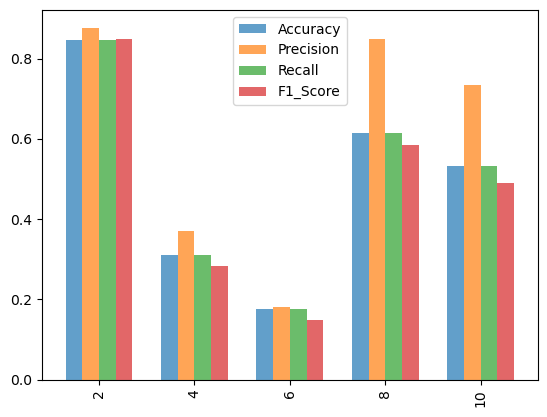

In [62]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

## Dishonest 

In [63]:
# Split data into 8 clients
client_1 = (x_train[0:7500], y_train[0:7500])
client_2 = (x_train[7500:15000], y_train[7500:15000])
client_3 = (x_train[15000:22500], y_train[15000:22500])
client_4 = (x_train[22500:30000], y_train[22500:30000])
client_5 = (x_train[30000:37500], y_train[30000:37500])
client_6 = (x_train[37500:45000], y_train[37500:45000])
client_7 = (x_train[45000:52500], y_train[45000:52500])
client_8 = (x_train[52500:], y_train[52500:]) 

In [64]:
client_7[1].size

7500

In [65]:
client_7[1]

array([3, 1, 1, ..., 7, 1, 4], dtype=uint8)

In [66]:
client_7[1][:7000] = 7

In [67]:
client_7[1]

array([7, 7, 7, ..., 7, 1, 4], dtype=uint8)

In [68]:
print(client_1[0].shape)
print(client_2[0].shape)
print(client_3[0].shape)
print(client_4[0].shape)
print(client_5[0].shape)
print(client_6[0].shape)
print(client_7[0].shape)
print(client_8[0].shape)

print(client_1[1].shape)
print(client_2[1].shape)
print(client_3[1].shape)
print(client_4[1].shape)
print(client_5[1].shape)
print(client_6[1].shape)
print(client_7[1].shape)
print(client_8[1].shape)

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [69]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, client_1[0], client_1[1])
client2_model = train_client_model(client2_model, client_2[0], client_1[1])
client3_model = train_client_model(client3_model, client_3[0], client_1[1])
client4_model = train_client_model(client4_model, client_4[0], client_1[1])
client5_model = train_client_model(client5_model, client_5[0], client_1[1])
client6_model = train_client_model(client6_model, client_6[0], client_1[1])
client7_model = train_client_model(client7_model, client_7[0], client_1[1])
client8_model = train_client_model(client8_model, client_8[0], client_1[1])

Epoch 1/5
235/235 [==============================] - 3s 4ms/step - loss: 0.5688 - accuracy: 0.8433
Epoch 2/5
235/235 [==============================] - 1s 6ms/step - loss: 0.2565 - accuracy: 0.9264
Epoch 3/5
235/235 [==============================] - 2s 7ms/step - loss: 0.1897 - accuracy: 0.9465
Epoch 4/5
235/235 [==============================] - 3s 11ms/step - loss: 0.1463 - accuracy: 0.9592
Epoch 5/5
235/235 [==============================] - 4s 18ms/step - loss: 0.1136 - accuracy: 0.9685
Epoch 1/5
235/235 [==============================] - 6s 16ms/step - loss: 2.3189 - accuracy: 0.1039
Epoch 2/5
235/235 [==============================] - 3s 12ms/step - loss: 2.2918 - accuracy: 0.1244
Epoch 3/5
235/235 [==============================] - 2s 10ms/step - loss: 2.2745 - accuracy: 0.1403
Epoch 4/5
235/235 [==============================] - 2s 9ms/step - loss: 2.2494 - accuracy: 0.1639
Epoch 5/5
235/235 [==============================] - 1s 5ms/step - loss: 2.2182 - accuracy: 0.1821
Epoch

In [70]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(), 
                                               client6_model.get_weights(), 
                                               client7_model.get_weights(),
                                               client8_model.get_weights())
                                             
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [71]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 3s - loss: 2.2943 - accuracy: 0.2609 - 3s/epoch - 9ms/step
Test accuracy: 0.26089999079704285
313/313 [==============================] - 2s 6ms/step
(10000, 10)
Accuracy test set:  0.2609
Precision test set:  0.26593553168850154
Recall test set:  0.2609
F-score test set:  0.18300969610277026
              precision    recall  f1-score   support

           0       0.12      0.02      0.03       980
           1       0.28      0.93      0.42      1135
           2       0.42      0.05      0.10      1032
           3       0.00      0.00      0.00      1010
           4       0.50      0.09      0.15       982
           5       0.54      0.08      0.13       892
           6       0.44      0.35      0.39       958
           7       0.24      0.59      0.34      1028
           8       0.17      0.40      0.24       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.26     10000
   macro avg       0.27      0.25      0.18    

In [72]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [73]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.2609)
test_precision_dishonest.append(0.26593553168850154)
test_recall_dishonest.append(0.2609)
test_f1_score_dishonest.append(0.18300969610277026)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.1768, 0.2609]
[0.18168698182650236, 0.26593553168850154]
[0.1768, 0.2609]
[0.14958748329847868, 0.18300969610277026]


In [74]:
### Plot the model's performance for the 4 clients, one of them (number=3) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#7 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.1768, 0.2609], [0.18168698182650236, 0.26593553168850154], [0.1768, 0.2609], [0.14958748329847868, 0.18300969610277026]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.1768,0.181687,0.1768,0.149587
#7 is dishonest,0.2609,0.265936,0.2609,0.183010


<Axes: >

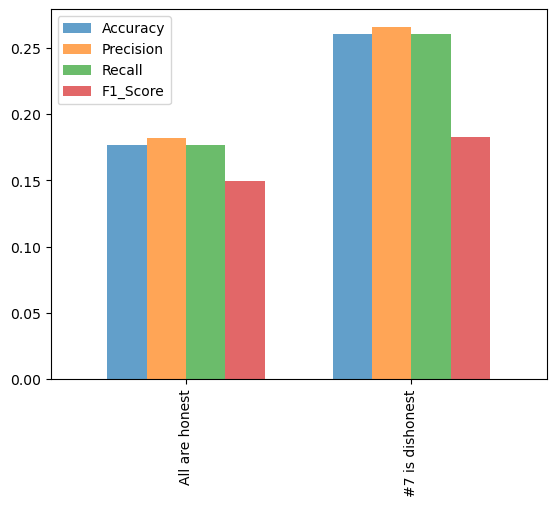

In [75]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.




# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.

